## import the dependencies

In [9]:
from scipy.fftpack import fft2, fftshift
import math
import matplotlib.pyplot as plt
import numpy as np
from zernike_generator import zernikegenerator
import tifffile

## set up the aberrations in terms of zernike modes

In [15]:
zernike_modes = zernikegenerator(5, 450)

## set up the simulaion parameters regarding the grating array

In [10]:
SLM_display_dim = np.zeros([450, 450])
input_n_element = 5
rms_amplitude = 0.5
single_holo_dim = int(len(SLM_display_dim)/input_n_element)
initial_frequency_x = 15
initial_frequency_y = 15
increment_xy = 6
topological_charge = 0

In [11]:
rows = np.arange(-1, 1, 2 / (single_holo_dim))
column = np.arange(-1, 1, 2 / (single_holo_dim))
Rows, Columns = np.meshgrid(rows, column)
z_tan = np.arctan2(Columns, Rows)


## make the grating array 

In [12]:

for m in range(input_n_element):
    for n in range(input_n_element):
        x_frequency = initial_frequency_x + m * increment_xy
        y_frequency = initial_frequency_y + n * increment_xy
        hologram = np.cos(math.pi * (Rows * x_frequency +
                                     Columns * y_frequency) +
                          topological_charge * z_tan)  
        circle = np.sqrt(Rows ** 2 + Columns ** 2) < 1
        circ_hologram = np.multiply(hologram, circle) > 0
        SLM_display_dim[m * (single_holo_dim): (m + 1) * (single_holo_dim ),
        n * (single_holo_dim ): (n + 1) * (single_holo_dim )] = circ_hologram



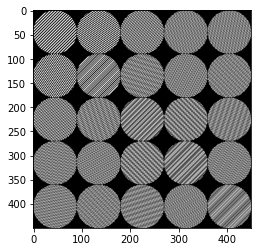

In [13]:
plt.figure()
plt.imshow(SLM_display_dim, cmap='gray')
plt.show()

## disaplay the focal spot array for a plane wavefront

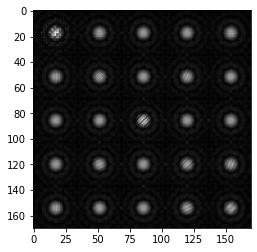

In [14]:
fourier_plane = fftshift(fft2(SLM_display_dim,[512, 512]))
abs_fourier_plane = np.abs(fourier_plane)
focal_spots_reference = abs_fourier_plane[324:494,324:494]

plt.figure()
plt.imshow(focal_spots_reference, cmap='gray')

plt.show()

In [16]:
tifffile.imwrite('datasets/reference.tif', focal_spots_reference)

## display focal spos for aberrated beam

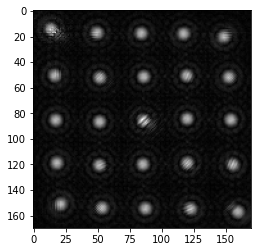

In [75]:
aberration =  0.6*zernike_modes[5] + 0.2*zernike_modes[8] + 0.3*zernike_modes[10]

Add_aberration = SLM_display_dim * np.exp(1j*( aberration))
aberrated_focal_spots = fftshift(fft2(Add_aberration,[512,512]))
abs_aberrated_focal_spots = np.abs(aberrated_focal_spots)
focal_spots = abs_aberrated_focal_spots[324:494,324:494]

plt.figure()
plt.imshow(focal_spots , cmap='gray')

plt.show()

## make training dataset

In [86]:
poisson_scale_factor = 100
gaussian_noise_std = 5

number_of_data = 5500
number_of_zernike_modes = 12
spots_array = np.zeros((number_of_data, 180, 180), dtype='float32')
aberration_strengths = np.random.uniform(-0.5, 0.5, (number_of_data, number_of_zernike_modes))  
aberrations = [zernike_modes[i+3] for i in range(number_of_zernike_modes)]


crop_x_start, crop_x_end = 320, 500
crop_y_start, crop_y_end = 320, 500

for i in range(number_of_data):

    aberration = np.sum(aberration_strengths[i, :, np.newaxis, np.newaxis] * np.array(aberrations), axis=0)

    Add_aberration = SLM_display_dim * np.exp(1j * aberration)
    aberrated_focal_spots = fftshift(fft2(Add_aberration, [512, 512]))
    
    spots = np.random.poisson(np.abs(aberrated_focal_spots)[crop_x_start:crop_x_end, crop_y_start:crop_y_end]) 
    
    focal_spots_poisson = np.random.poisson(spots * poisson_scale_factor) / poisson_scale_factor
    focal_spots_noisy = focal_spots_poisson + np.random.normal(0, gaussian_noise_std, focal_spots_poisson.shape)
    
    spots_array[i] = focal_spots_noisy.astype('float32')



[-0.30960149 -0.49140911 -0.09196419 -0.27266544  0.02792574 -0.0446247
 -0.3611096  -0.37374409 -0.46358794 -0.24366312 -0.24148881 -0.26372787]


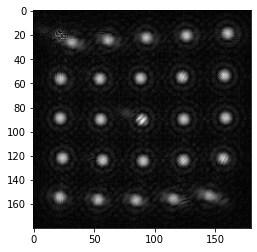

In [87]:
number = 999
plt.figure()
plt.imshow(spots_array[number], cmap='gray')
print(aberration_strengths[number])
plt.show()

In [88]:
tifffile.imwrite('datasets/training_5000.tif', spots_array)
np.save('datasets/training_5000.npy', aberration_strengths)

## test data generation

In [ ]:
poisson_scale_factor = 100
gaussian_noise_std = 5

spots_array = np.zeros((12, 180,180), dtype='float32')
aberration_strengths = []
for i in range(12):
    # Add aberration in the holograms
    # for j in range(15):
    aberration = 0.5 * zernike_modes[i+3]

    Add_aberration = SLM_display_dim * np.exp(1j*( aberration))
    aberrated_focal_spots = fftshift(fft2(Add_aberration,[512,512]))
    abs_aberrated_focal_spots = np.abs(aberrated_focal_spots)
    focal_spots = abs_aberrated_focal_spots[320:500,320:500]
    
    # Add Poisson noise
    focal_spots_poisson = np.random.poisson(focal_spots * poisson_scale_factor) / poisson_scale_factor
    # Add Gaussian noise
    focal_spots_noisy = focal_spots_poisson + np.random.normal(0, gaussian_noise_std, focal_spots_poisson.shape)
    spots_array[i] = focal_spots_noisy.astype('float32')

In [ ]:
tifffile.imwrite('datasets/test_z4_z15_0.5.tif', spots_array)
np.save('datasets/test_z4_z15_0.5.npy', 0.5*np.identity(12))